In [1]:
from __future__ import print_function
from time import time
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import pandas as pd
from scipy.spatial.distance import cdist as cdi
import jieba, string
from zhon.hanzi import punctuation
import re

In [2]:
data = pd.read_excel('0814.xls')
useful = data.iloc[:,[0,1,7,8,10,12,28]]
useful.columns = ['name', 'gender', 'birthdate','race','degree','topic','text']
useful = useful.dropna(subset=['name','topic','text'])
data2 = pd.read_excel('0814-2.xls')
data2  = data2.iloc[:,[27]]
data2.columns = ['text']
data2 = data2.dropna()

In [3]:
# parameters
n_features = 100 
n_components = 20
n_top_words = 30

In [4]:
# load files
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


In [5]:
# stack manuscripts and reviewers' abstracts
t0 = time()
data_samples = useful['text']
dl = pd.Series.tolist(data_samples)
ml = pd.Series.tolist(data2['text'])
alltext = dl+ml
print("done in %0.3fs." % (time() - t0))


done in 0.001s.


In [6]:
segment_jieba = lambda text: " ".join(jieba.cut(text))
corpus = []
for line in alltext:
    corpus.append(segment_jieba(line.replace(punctuation,'')))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.555 seconds.
Prefix dict has been built succesfully.


In [7]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.02, max_features=n_features)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(corpus)
print("size:  ")
print(tfidf.shape)
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features for NMF...
size:  
(1290, 100)
done in 0.417s.


In [8]:
# Return topics
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))
print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=100...
done in 1.278s.

Topics in NMF model (generalized Kullback-Leibler divergence):
Topic #0: 来源 技术 采用 成果 应用 推广应用 通过 研究 范围 进行 降低 问题 目前 比较 过程 达到 提高 条件 具有 国内外 以及 影响 试验 项目 存在 主要 作用 减少 不同 有效
Topic #1: 治疗 课题 患者 疗效 临床 05 药物 比较 对照组 联合 明显 结合 有效 功能 显著 意义 对于 发生 术后 水平 分析 改善 手术 研究 工作 效果 方法 作用 指标 方案
Topic #2: 河北省 课题 创新 项目 开发 存在 安全 实现 对于 对照组 工作 工艺 应用 形成 增加 影响 性能 患者 情况 意义 成果 手术 技术 指标 控制 处理 国内外 基础 提供 10
Topic #3: 工作 研究 项目 开发 处理 存在 安全 实现 对于 对照组 工艺 应用 形成 基础 影响 性能 患者 情况 意义 成果 手术 技术 指标 控制 增加 国内外 提供 国内 10 一种
Topic #4: 性能 要求 产品 工艺 生产 开发 结构 工作 设计 材料 研发 使用 功能 目前 增加 方式 提高 实现 国内 可以 时间 达到 设备 效果 形成 存在 一种 具有 通过 发展
Topic #5: 存在 施工 安全 同时 控制 结构 对于 混凝土 设计 影响 增加 材料 过程 方式 发展 性能 发生 采用 具有 条件 减少 通过 要求 作用 试验 标准 达到 分析 效果 质量
Topic #6: 技术 施工 混凝土 开发 处理 存在 安全 实现 对于 对照组 工作 工艺 应用 项目 形成 增加 性能 患者 情况 意义 成果 手术 指标 控制 影响 基础 提供 具有 10 一种
Topic #7: 研究 材料 技术 主要 变压器 项目 应用 存在 安全 实现 对于 对照组 工作 工艺 形成 开发 增加 影响 性能 患者 情况 意义 成果 手术 指

In [9]:
# mask out manuscripts and abstracts not related to all topics
review_topic = nmf.fit_transform(tfidf)
sep = len(dl)
mt = review_topic[:sep,:]
rt = review_topic[sep+1:,:]
mask1 = np.ones(len(mt), dtype=bool)
mask2 = np.ones(len(rt), dtype=bool)
mas_p1 = []
mas_p2 = []
for i in range(len(mt)):
    if np.all(mt[i,:]==0):
        mas_p1.append(i)
for i in range(len(rt)):
    if np.all(rt[i,:]==0):
        mas_p2.append(i)
mas_p1.remove(89)
mask1[mas_p1] = False
mask2[mas_p2] = False
mt = mt[mask1,...]
rt = rt[mask2,...]

In [10]:
pool = useful.drop(mas_p1)
things = data2.drop(mas_p2)

In [11]:
# caluclate cosine distance
res = cdi(rt,mt,'cosine')
np.savetxt('res_dis.txt', res, fmt='%f')

In [12]:
res.shape

(854, 378)

In [46]:
# produce result
chosen = []
count = 0
for i in range(len(res)):
    top10 = res[i,:].argsort()[2:32]
    target = things.iloc[i,:]['text']
    names = []
    for j in top10:
        if(res[i,j]>0.5 and np.argwhere(top10==j)==0):
            print("No matched reviewer for this one!")
            count+=1
            break
        names.append(str(pool.iloc[[j],:]['name'].values[0]))
    print(names)

No matched reviewer for this one!
[]
No matched reviewer for this one!
[]
['李建勋', '张步勤', '张学东', '马静', '崔晓冬', '郑丽锦', '陈胜锁', '代晓茹', '黄刚', '侯万彬', '刘丽君', '杨文香', '刘彬', '赵民', '权万里', '翟军军', '刘辉', '王鑫', '田粟', '任爱国', '史志刚', '马腾壑', '张树峰\u3000', '赵侠', '张纪英', '陈晓洁', '焦永倩', '郑文凯', '张峰', '张翠婷']
No matched reviewer for this one!
[]
No matched reviewer for this one!
[]
No matched reviewer for this one!
[]
['杨俊琦', '焦永倩', '张博洋', '白云龙', '张长声', '尹建华', '张立玮', '史志刚', '高海瑞', '张纪英', '辛双会', '刘晓慧1', '于存国', '李勇', '王彦刚', '相艳丽', '张英杰', '杨新振', '尹新彦', '王永霞', '王锦涛', '于萍', '吴向荣', '于红', '朱永涛', '张长俊', '袁香坤', '陈晓洁', '侯万彬', '刘春鹏']
No matched reviewer for this one!
[]
['杨俊琦', '张博洋', '张长声', '白云龙', '史志刚', '柴东升', '李挥', '潘志远', '梁玉芹', '段丽娟', '刘冉', '张纪英', '尹建华', '殷惠民', '刘晓慧1', '张英杰', '牛玉鹏', '高海瑞', '于存国', '彭九慧', '赵志强', '郭琳', '赵民', '李勇', '王宪军', '米红梅', '陈晓明', '胡万宁', '侯万彬', '李广义']
['李建勋', '张步勤', '马静', '张学东', '陈胜锁', '崔晓冬', '郑丽锦', '代晓茹', '黄刚', '侯万彬', '刘丽君', '杨文香', '刘彬', '赵民', '权万里', '翟军军', '刘辉', '王鑫', '田粟', '任爱国', '郭敬芬', '武大勇', '赵侠', 

['张建英', '肖继君', '庞荣丽', '吕丽华', '张丽华', '郭延凯', '李彬', '王彦成\u3000', '毛向红', '燕春霞', '苏新爱', '庞昭进', '张立新', '王学静', '张文倩', '赵玉斌', '张伟峰', '王立红', '王华英\u3000', '张艳卿', '张祥宏\u3000', '刘冲', '和东芹', '吴明月', '黄', '赵彩彦', '边劲松', '朱运杰', '王伟', '孙丽敏']
No matched reviewer for this one!
[]
['张立玮', '相艳丽', '王永霞', '王锦涛', '侯万彬', '张海中', '朱永涛', '郑焕然', '李军乐', '李利平', '李明莉', '毛利荣', '郭毅环', '武智', '张丽', '王晓', '崔志刚', '刘花粉', '单春光', '白浩伟', '田景汉', '赵邦荣', '安海峰', '张英杰', '董世山', '顾利平', '狄岩', '李霞', '檀', '李腾飞']
No matched reviewer for this one!
[]
['孙源蔚', '张亦心', '张春荣', '郝海琴', '郑慧敏', '马兴树', '王秀粉', '杨素苗', '和东芹', '孙洪新', '田粟', '尹建华', '丁翠青', '刘红茹', '周占兵', '李腾飞', '任爱国', '赵玉斌', '董世山', '刘辉', '梁久杰', '杜朋', '张宏彦', '尹庆珍', '陈海峰', '张鹤平', '陈晓洁', '刘伯', '侯万彬', '刘春鹏']
['高明', '马静', '张步勤', '李建勋', '张学东', '崔晓冬', '郑丽锦', '代晓茹', '赵民', '黄刚', '刘丽君', '刘彬', '杨文香', '侯万彬', '刘伯', '权万里', '翟军军', '牛玉鹏', '史志刚', '刘辉', '郭敬芬', '武大勇', '刘冉', '段丽娟', '梁玉芹', '李挥', '潘志远', '王鑫', '张鹤平', '杨俊琦']
['朱永涛', '于萍', '鲁俊奇', '袁瑞江', '尹庆珍', '赵国军', '郭琳', '赵志强', '陈晓明', '潘志远', '李挥', '刘冉', '梁玉芹', '段

['刘晓慧1', '聂书海', '郭金英', '李敬三', '李建忠', '马强', '周志刚', '李俊杰', '贾永祥', '张长声', '赵玉成', '刘海萍', '艾治国', '秦彦梅', '耿炎', '李占行', '潘秀清', '赵烁', '王鑫', '胡万宁', '白云龙', '吴向荣', '庞义存', '王宪军', '郭兰英', '杨俊琦', '檀', '李霞', '张纪英', '范京惠']
['高海瑞', '焦艳平', '贾秀领', '马晓荣', '张淑青', '张萌', '李利', '魏建伟', '刘金哲', '岳海旺', '杨明', '马香玲', '李士学', '杨德强', '耿保进', '刘子英', '曹岩坡', '席景', '刘忠宽', '谢俊良', '王玉忠', '游永亮', '姬鹏', '薛增明', '李文莹', '多伶俐', '郑素月', '周万勇', '檀朝彬', '郭玉妍']
['王彦刚', '尹新彦', '张纪英', '吴向荣', '朱运杰', '于红', '冉宝兴', '郭敬芬', '武大勇', '刘建钗', '刘春鹏', '贾秀领', '张海中', '杨春燕', '徐振华', '郝洪波', '姜奎年', '刘胜海', '张长俊', '鲁俊奇', '陈海峰', '梁军\u3000', '边劲松', '赵彩彦', '张宏彦', '王新娜', '李松涛', '崔瑞雪', '段新峰', '杨金良']
['李明莉', '李利平', '崔志刚', '李军乐', '田景汉', '刘花粉', '张丽', '白浩伟', '武智', '王晓', '郑焕然', '毛利荣', '单春光', '赵邦荣', '侯万彬', '安海峰', '张英杰', '顾利平', '董世山', '狄岩', '张海中', '李霞', '檀', '彭九慧', '李源', '李腾飞', '黄刚', '耿立格', '焦永刚', '白石']
['张立玮', '相艳丽', '王锦涛', '王永霞', '辛双会', '王彦刚', '朱永涛', '尹新彦', '陈晓洁', '吴向荣', '于红', '侯万彬', '刘春鹏', '张纪英', '张长俊', '张海中', '吴清池', '杜朋', '袁香坤', '林永君', '张立新', '戴茂华', '庞艳雷', '张树峰\u3000', 

['梁玉芹', '刘冉', '李挥', '段丽娟', '柴东升', '郭琳', '赵志强', '殷惠民', '刘伯', '米红梅', '陈晓明', '牛玉鹏', '李广义', '张丽娟', '王彦刚', '胡万宁', '赵民', '焦永倩', '张占国', '高慧敏', '彭九慧', '底建敏', '张伟峰', '郭兰英', '杨俊琦', '张立玮', '张纪英', '张鹤平', '张博洋', '白云龙']
No matched reviewer for this one!
[]
['李挥', '段丽娟', '梁玉芹', '刘冉', '米红梅', '王彦刚', '柴东升', '郭琳', '赵志强', '张占国', '殷惠民', '刘伯', '陈晓明', '牛玉鹏', '李广义', '张丽娟', '底建敏', '胡万宁', '张伟峰', '赵民', '于红', '尹新彦', '高慧敏', '彭九慧', '辛双会', '王占平', '洪查理', '冯志杰', '马文讯', '冯新旺']
['赵国军', '朱永涛', '鲁俊奇', '杨志杰', '张春来', '董灵迪', '杨淑莲', '冯建忠', '胡雅萍', '李振江', '韩占刚', '张宪静', '尹立府', '于萍', '李相运', '乔文臣', '翟军军', '吴明月', '贡瑞霞', '史志刚', '刘红茹', '李明良', '杨金良', '张翠婷', '张峰', '丁志强', '郑文凯', '尹庆珍', '王越辉', '郝建峰']
['郑丽锦', '崔晓冬', '刘彬', '杨文香', '焦永倩', '张鹤平', '赵民', '李建勋', '张步勤', '张学东', '马静', '高明', '刘伯', '权万里', '张树峰\u3000', '马腾壑', '陈胜锁', '梁春耕', '郭嘉红', '卜俊周', '吴颖欣', '杨文香', '张秀云', '程会娜', '王莉萍', '赵艳', '张永英', '高绍芳', '袁香坤', '代晓茹']
No matched reviewer for this one!
[]
['段丽娟', '梁玉芹', '潘志远', '李挥', '赵民', '柴东升', '赵志强', '郭琳', '张学东', '李建勋', '马静', '张步勤', '高明', '刘伯', '殷

['陈胜锁', '李建忠', '周志刚', '聂书海', '郭金英', '李俊杰', '贾永祥', '马强', '李敬三', '赵烁', '王鑫', '赵玉成', '刘晓慧1', '翟军军', '郭敬芬', '武大勇', '任爱国', '于存国', '李占行', '秦彦梅', '艾治国', '潘秀清', '耿炎', '李凤伟', '范京惠', '张桂兰', '乔文臣', '李相运', '孙丽敏', '童莉']
No matched reviewer for this one!
[]
['杨素苗', '张亦心', '孙源蔚', '高永海', '郑慧敏', '张春荣', '郝海琴', '王秀粉', '和东芹', '孙洪新', '田粟', '尹建华', '丁翠青', '刘辉', '任爱国', '刘红茹', '周占兵', '李腾飞', '赵玉斌', '董世山', '梁久杰', '杜朋', '王鑫', '郝光飞', '潘秀清', '艾治国', '秦彦梅', '耿炎', '李占行', '张宏彦']
No matched reviewer for this one!
[]
['杨俊琦', '张纪英', '张博洋', '史志刚', '郑文凯', '丁志强', '张翠婷', '张峰', '杨金良', '李明良', '白云龙', '张长声', '柳斌辉', '尹建华', '高海瑞', '王立红', '王宪军', '赵向寨', '马文会', '鲁俊奇', '于存国', '刘晓慧1', '李勇', '贾秀领', '孙东辉', '刘建钗', '孙玉娟', '梁军\u3000', '张英杰', '苏国权']
['郭兰英', '张博洋', '白云龙', '张长声', '尹建华', '史志刚', '高海瑞', '张纪英', '于存国', '刘晓慧1', '李勇', '张英杰', '于萍', '杨新振', '辛双会', '王彦刚', '尹新彦', '吴向荣', '于红', '庞艳雷', '戴茂华', '张长俊', '王锦涛', '李昶恒', '袁香坤', '朱运杰', '杜朋', '侯万彬', '陈晓洁', '张树峰\u3000']
['范京惠', '冯新旺', '申霞', '洪查理', '郭影', '薛艳梅', '冯志杰', '裴永生', '马文讯', '孙文耕', '杜桂香', '白雪景', '

['张立玮', '相艳丽', '王永霞', '王锦涛', '李明良', '丁志强', '杨金良', '郑文凯', '张翠婷', '张峰', '王宪军', '柳斌辉', '赵向寨', '赵烁', '苏国权', '孙玉娟', '李凤伟', '范京惠', '牛新胜', '于红', '王立红', '刘冲', '贾永祥', '郭金英', '马强', '李敬三', '周志刚', '李建忠', '李俊杰', '聂书海']
No matched reviewer for this one!
[]
['王彦刚', '尹新彦', '张长俊', '袁香坤', '张祥宏\u3000', '张艳卿', '陈晓洁', '张树峰\u3000', '吴向荣', '吴清池', '于红', '杜朋', '武大勇', '郭敬芬', '张立新', '庞昭进', '郭延凯', '庞荣丽', '张丽华', '王彦成\u3000', '苏新爱', '毛向红', '肖继君', '吕丽华', '张建英', '燕春霞', '李彬', '高绍芳', '郭嘉红', '程会娜']
['张立新', '张祥宏\u3000', '张艳卿', '庞昭进', '庞荣丽', '张丽华', '张建英', '郭延凯', '吕丽华', '肖继君', '燕春霞', '苏新爱', '毛向红', '王彦成\u3000', '李彬', '王学静', '张文倩', '王立红', '朱永涛', '赵玉斌', '张伟峰', '吕振宇', '郭敬芬', '武大勇', '王伟', '王华英\u3000', '尹庆珍', '鲁俊奇', '朱运杰', '吴清池']
['郭延凯', '毛向红', '王彦成\u3000', '李彬', '苏新爱', '肖继君', '张建英', '燕春霞', '张丽华', '吕丽华', '庞荣丽', '庞昭进', '张立新', '王学静', '赵玉斌', '张文倩', '张伟峰', '王立红', '王华英\u3000', '和东芹', '张艳卿', '张祥宏\u3000', '周志刚', '郭金英', '李俊杰', '贾永祥', '马强', '聂书海', '李建忠', '李敬三']
['张立玮', '相艳丽', '高明', '李建勋', '马静', '张步勤', '张学东', '王永霞', '张翠婷', '杨金良', '丁志强', '

['郭延凯', '张丽华', '肖继君', '庞荣丽', '吕丽华', '李彬', '王彦成\u3000', '毛向红', '燕春霞', '苏新爱', '张建英', '庞昭进', '赵玉斌', '张立新', '王学静', '张文倩', '张伟峰', '和东芹', '王立红', '王华英\u3000', '张艳卿', '张祥宏\u3000', '朱运杰', '刘冲', '吴明月', '边劲松', '赵彩彦', '黄', '王伟', '牛灵安']
['张立玮', '相艳丽', '王永霞', '王锦涛', '张翠婷', '张峰', '杨金良', '郑文凯', '丁志强', '李明良', '柳斌辉', '王宪军', '马文会', '王立红', '朱永涛', '赵向寨', '孙东辉', '鲁俊奇', '牛新胜', '孙玉娟', '梁军\u3000', '侯万彬', '贾秀领', '刘建钗', '代晓茹', '张纪英', '黄刚', '苏国权', '尹庆珍', '权万里']
['张学东', '李建勋', '张步勤', '高明', '崔晓冬', '郑丽锦', '陈胜锁', '代晓茹', '黄刚', '侯万彬', '刘丽君', '杨文香', '刘彬', '赵民', '刘辉', '权万里', '翟军军', '田粟', '任爱国', '王鑫', '马腾壑', '史志刚', '张树峰\u3000', '赵侠', '郝光飞', '陈晓洁', '张纪英', '刘春鹏', '焦永倩', '张海中']
['张建英', '肖继君', '庞荣丽', '吕丽华', '张丽华', '郭延凯', '李彬', '王彦成\u3000', '毛向红', '燕春霞', '苏新爱', '庞昭进', '张立新', '王学静', '赵玉斌', '张文倩', '张伟峰', '王立红', '王华英\u3000', '张艳卿', '张祥宏\u3000', '朱运杰', '刘冲', '和东芹', '赵彩彦', '边劲松', '吴明月', '黄', '王伟', '韩颖']
['张立玮', '相艳丽', '王永霞', '王锦涛', '朱永涛', '尹建华', '郭兰英', '杨俊琦', '张纪英', '张博洋', '白云龙', '辛双会', '张长声', '王彦刚', '尹新彦', '刘晓慧1', '李勇', '刘春鹏', '杜朋

['吕丽华', '燕春霞', '庞荣丽', '郭延凯', '苏新爱', '张丽华', '王彦成\u3000', '毛向红', '张建英', '李彬', '肖继君', '庞昭进', '张立新', '王学静', '张文倩', '戴茂华', '庞艳雷', '朱运杰', '赵玉斌', '张伟峰', '王立红', '王华英\u3000', '王锦涛', '张艳卿', '张祥宏\u3000', '李昶恒', '刘冲', '和东芹', '吴明月', '黄']
['武大勇', '张桂兰', '陈晓洁', '陈胜锁', '朱运杰', '王彦成\u3000', '郭延凯', '燕春霞', '张丽华', '庞荣丽', '吕丽华', '张建英', '苏新爱', '李彬', '毛向红', '肖继君', '庞昭进', '张立新', '牛玉鹏', '王学静', '赵玉斌', '张文倩', '刘海萍', '张伟峰', '王立红', '王华英\u3000', '张艳卿', '张祥宏\u3000', '刘冲', '和东芹']
['郭敬芬', '张桂兰', '陈胜锁', '牛玉鹏', '陈晓洁', '朱运杰', '刘海萍', '庞昭进', '苏新爱', '李彬', '张丽华', '吕丽华', '庞荣丽', '王彦成\u3000', '毛向红', '张建英', '郭延凯', '燕春霞', '肖继君', '张立新', '王立红', '王学静', '赵玉斌', '张文倩', '张伟峰', '王华英\u3000', '刘冲', '和东芹', '张祥宏\u3000', '张艳卿']
['张建英', '肖继君', '庞荣丽', '吕丽华', '张丽华', '郭延凯', '李彬', '王彦成\u3000', '毛向红', '燕春霞', '苏新爱', '庞昭进', '张立新', '王学静', '张文倩', '赵玉斌', '张伟峰', '王立红', '王华英\u3000', '张艳卿', '张祥宏\u3000', '刘冲', '和东芹', '吴明月', '黄', '朱运杰', '赵彩彦', '边劲松', '王伟', '孙丽敏']
['吕振宇', '朱永涛', '毛向红', '燕春霞', '张建英', '张丽华', '郭延凯', '庞荣丽', '吕丽华', '肖继君', '苏新爱', '李彬', '王彦成\u3000', 

['张祥宏\u3000', '王伟', '梁春耕', '程会娜', '杨文香', '王莉萍', '张秀云', '张永英', '赵艳', '高绍芳', '吴颖欣', '郭嘉红', '卜俊周', '刘春鹏', '袁香坤', '刘进余', '张长俊', '赵京献', '蔡寅宵', '左玉柱', '高社光', '杜朋', '张芦生', '吴清池', '刘建钗', '高慧敏', '孙东辉', '牛灵安', '刘彬', '杨文香']
['郑慧敏', '高永海', '孙源蔚', '郝海琴', '张亦心', '王秀粉', '马兴树', '杨素苗', '和东芹', '孙洪新', '王锦涛', '田粟', '丁翠青', '戴茂华', '庞艳雷', '尹建华', '李昶恒', '杜朋', '周占兵', '焦永倩', '尹庆珍', '刘红茹', '任爱国', '于萍', '李腾飞', '朱永涛', '梁久杰', '赵玉斌', '董世山', '刘辉']
['刘冉', '梁玉芹', '段丽娟', '潘志远', '胡万宁', '柴东升', '赵志强', '郭琳', '殷惠民', '米红梅', '张丽娟', '陈晓明', '牛玉鹏', '李广义', '刘晓慧1', '李建忠', '郭金英', '聂书海', '李敬三', '周志刚', '贾永祥', '马强', '李俊杰', '王彦刚', '赵玉成', '刘海萍', '赵民', '高慧敏', '庞义存', '于存国']
['潘志远', '刘冉', '梁玉芹', '段丽娟', '柴东升', '赵志强', '郭琳', '刘伯', '殷惠民', '米红梅', '陈晓明', '牛玉鹏', '李广义', '张丽娟', '胡万宁', '王彦刚', '赵民', '张占国', '高慧敏', '彭九慧', '张鹤平', '底建敏', '张伟峰', '陈晓洁', '侯万彬', '刘春鹏', '张纪英', '张海中', '吴清池', '林永君']
['段丽娟', '刘冉', '潘志远', '李挥', '赵志强', '郭琳', '陈晓明', '殷惠民', '柴东升', '刘伯', '赵民', '张丽娟', '米红梅', '牛玉鹏', '李广义', '高慧敏', '马文会', '张占国', '郑文凯', '丁志强', '张峰', '张翠婷', '杨金良', '王彦刚', '胡

['丁志强', '张峰', '郑文凯', '杨金良', '李明良', '柳斌辉', '张春荣', '高永海', '孙源蔚', '郝海琴', '郑慧敏', '张亦心', '马兴树', '王秀粉', '杨素苗', '王立红', '和东芹', '王宪军', '孙洪新', '鲁俊奇', '赵向寨', '田粟', '马文会', '尹建华', '尹庆珍', '丁翠青', '孙东辉', '刘红茹', '孙玉娟', '张纪英']
['戴茂华', '辛双会', '王锦涛', '李昶恒', '王彦刚', '吴向荣', '尹新彦', '朱运杰', '单保恩', '庞义存', '于红', '杨素苗', '于萍', '王鑫', '白云龙', '张纪英', '杜朋', '李敬三', '李俊杰', '周志刚', '贾永祥', '马强', '聂书海', '李建忠', '郭金英', '杨川杰', '赵玉成', '刘晓慧1', '刘春鹏', '张海中']
['杨志杰', '张宪静', '张春来', '李振江', '董灵迪', '杨淑莲', '韩占刚', '冯建忠', '尹立府', '李相运', '乔文臣', '翟军军', '贡瑞霞', '吴明月', '刘红茹', '田占霄', '路露', '韩颖', '王越辉', '马登斌', '庞宇慧', '张东风', '刘玉平', '郝建峰', '段公', '冯登超', '赵国军', '王伟', '史志刚', '郭延华']
No matched reviewer for this one!
[]
['王彦刚', '尹新彦', '郭兰英', '杨俊琦', '张博洋', '史志刚', '张纪英', '白云龙', '张长声', '吴向荣', '尹建华', '于红', '高海瑞', '张长俊', '刘晓慧1', '于存国', '李勇', '袁香坤', '张英杰', '张树峰\u3000', '高明', '张学东', '李建勋', '张步勤', '马静', '杨新振', '于萍', '陈胜锁', '崔晓冬', '郑丽锦']
['庞艳雷', '王锦涛', '李昶恒', '朱运杰', '武大勇', '郭敬芬', '杜朋', '于萍', '单保恩', '陈晓洁', '张桂兰', '白云龙', '牛新胜', '彭九慧', '陈胜锁', '牛玉鹏', '殷惠民', '侯万彬', '刘

['郭兰英', '尹建华', '张博洋', '张长声', '张纪英', '白云龙', '高海瑞', '刘晓慧1', '史志刚', '于存国', '李勇', '杨素苗', '马兴树', '郝海琴', '郑慧敏', '孙源蔚', '张春荣', '张亦心', '高永海', '刘春鹏', '林永君', '于萍', '王秀粉', '陈晓洁', '吴清池', '张英杰', '和东芹', '孙洪新', '侯万彬', '田粟']
['赵玉斌', '孙源蔚', '张春荣', '郑慧敏', '高永海', '郝海琴', '张亦心', '陈晓洁', '马兴树', '王秀粉', '杨素苗', '孙洪新', '张建英', '张丽华', '肖继君', '王彦成\u3000', '燕春霞', '毛向红', '郭延凯', '李彬', '苏新爱', '吕丽华', '庞荣丽', '庞昭进', '田粟', '尹建华', '张立新', '丁翠青', '王学静', '杜朋']
['郭敬芬', '张桂兰', '牛玉鹏', '陈胜锁', '刘海萍', '侯万彬', '朱运杰', '张海中', '陈晓洁', '刘春鹏', '张纪英', '吴清池', '张立新', '王彦刚', '柴东升', '王云', '林永君', '殷惠民', '段丽娟', '刘冉', '潘志远', '梁玉芹', '李挥', '杜朋', '彭九慧', '刘晓慧1', '米红梅', '辛双会', '高社光', '刘月琴']
['张步勤', '李建勋', '马静', '张学东', '高明', '崔晓冬', '郑丽锦', '代晓茹', '黄刚', '武大勇', '郭敬芬', '侯万彬', '刘彬', '杨文香', '朱运杰', '刘丽君', '刘辉', '张纪英', '赵民', '张海中', '刘春鹏', '权万里', '姜奎年', '郝洪波', '刘胜海', '徐振华', '杨春燕', '陈海峰', '翟军军', '史志刚']
['杨俊琦', '张博洋', '白云龙', '张英杰', '张纪英', '张长声', '柴东升', '刘晓慧1', '侯万彬', '尹建华', '殷惠民', '李勇', '牛玉鹏', '史志刚', '高海瑞', '张海中', '彭九慧', '段丽娟', '刘冉', '李挥', '潘志远', '梁玉芹', '于存国', '米红梅

['刘冉', '潘志远', '李挥', '段丽娟', '殷惠民', '柴东升', '刘伯', '赵志强', '郭琳', '米红梅', '陈晓明', '牛玉鹏', '李广义', '张丽娟', '彭九慧', '王彦刚', '赵民', '胡万宁', '戴茂华', '庞艳雷', '张占国', '高慧敏', '王锦涛', '李昶恒', '张鹤平', '底建敏', '张伟峰', '杜朋', '陈晓洁', '侯万彬']
['朱永涛', '于萍', '尹庆珍', '刘晓慧1', '鲁俊奇', '袁瑞江', '于存国', '张长声', '檀', '李霞', '尹建华', '赵国军', '侯万彬', '白云龙', '郭兰英', '杨俊琦', '张英杰', '聂书海', '李敬三', '李建忠', '李俊杰', '郭金英', '周志刚', '贾永祥', '马强', '赵玉成', '孙洪新', '刘海萍', '董世山', '张纪英']
No matched reviewer for this one!
[]
['武大勇', '陈晓洁', '张建英', '张丽华', '肖继君', '燕春霞', '庞荣丽', '吕丽华', '郭延凯', '苏新爱', '毛向红', '李彬', '王彦成\u3000', '庞昭进', '张立新', '王学静', '张文倩', '赵玉斌', '朱运杰', '张伟峰', '吕振宇', '张桂兰', '王立红', '陈胜锁', '王华英\u3000', '张艳卿', '张祥宏\u3000', '朱永涛', '牛玉鹏', '刘冲']
['朱永涛', '于萍', '陈晓洁', '郭兰英', '杨俊琦', '王彦成\u3000', '燕春霞', '庞荣丽', '张丽华', '吕丽华', '张建英', '苏新爱', '李彬', '毛向红', '郭延凯', '肖继君', '庞昭进', '张立新', '张博洋', '王学静', '张文倩', '史志刚', '白云龙', '张长声', '赵玉斌', '鲁俊奇', '张伟峰', '王立红', '尹建华', '袁瑞江']
['张建英', '肖继君', '庞荣丽', '吕丽华', '张丽华', '郭延凯', '李彬', '王彦成\u3000', '毛向红', '燕春霞', '苏新爱', '庞昭进', '张立新', '王学静', '张文倩'

['张建英', '肖继君', '庞荣丽', '吕丽华', '郭延凯', '李彬', '王彦成\u3000', '毛向红', '燕春霞', '苏新爱', '张丽华', '庞昭进', '张立新', '王学静', '张文倩', '赵玉斌', '张伟峰', '王立红', '王华英\u3000', '张艳卿', '张祥宏\u3000', '郭敬芬', '武大勇', '朱运杰', '刘冲', '和东芹', '吴明月', '黄', '赵彩彦', '边劲松']
['张建英', '肖继君', '庞荣丽', '吕丽华', '张丽华', '郭延凯', '李彬', '王彦成\u3000', '毛向红', '燕春霞', '苏新爱', '庞昭进', '张立新', '王学静', '张文倩', '赵玉斌', '张伟峰', '王立红', '王华英\u3000', '张艳卿', '张祥宏\u3000', '刘冲', '和东芹', '吴明月', '黄', '赵彩彦', '边劲松', '朱运杰', '王伟', '孙丽敏']
['武大勇', '辛双会', '王彦刚', '陈胜锁', '尹新彦', '张桂兰', '牛玉鹏', '朱运杰', '张纪英', '张海中', '刘海萍', '刘建钗', '梁军\u3000', '冉宝兴', '刘春鹏', '鲁俊奇', '姜奎年', '郝洪波', '徐振华', '刘胜海', '杨春燕', '侯万彬', '陈海峰', '崔瑞雪', '王新娜', '李松涛', '吴向荣', '张长俊', '赵防震', '姜玉松']
['郭兰英', '张博洋', '张长声', '白云龙', '史志刚', '尹建华', '张纪英', '高海瑞', '刘晓慧1', '于存国', '李勇', '张英杰', '张峰', '张翠婷', '杨金良', '郑文凯', '丁志强', '杨新振', '李明良', '柳斌辉', '于萍', '王宪军', '王立红', '赵向寨', '马文会', '鲁俊奇', '侯万彬', '孙东辉', '孙玉娟', '牛新胜']
['陈晓洁', '张峰', '丁志强', '郑文凯', '杨金良', '张翠婷', '庞昭进', '王彦成\u3000', '李彬', '苏新爱', '毛向红', '燕春霞', '吕丽华', '郭延凯', '庞荣丽', '肖继君', '张丽华', '张

['张立玮', '相艳丽', '辛双会', '王永霞', '王锦涛', '王彦刚', '朱永涛', '尹新彦', '吴向荣', '于红', '张长俊', '张鹤平', '刘伯', '袁香坤', '张纪英', '刘春鹏', '张海中', '张树峰\u3000', '陈晓洁', '侯万彬', '吴清池', '王云', '姜奎年', '刘胜海', '郝洪波', '徐振华', '杨春燕', '陈海峰', '边劲松', '赵彩彦']
No matched reviewer for this one!
[]
['杨俊琦', '史志刚', '张博洋', '陈晓洁', '张长声', '白云龙', '苏新爱', '郭延凯', '燕春霞', '张建英', '李彬', '庞荣丽', '毛向红', '张丽华', '王彦成\u3000', '吕丽华', '肖继君', '庞昭进', '张文倩', '尹建华', '张立新', '张纪英', '高海瑞', '王学静', '王华英\u3000', '张伟峰', '赵玉斌', '吴明月', '杨新振', '刘晓慧1']
No matched reviewer for this one!
[]
No matched reviewer for this one!
[]
No matched reviewer for this one!
[]
['艾治国', '李占行', '潘秀清', '秦彦梅', '赵玉成', '王鑫', '吴向荣', '刘晓慧1', '贾永祥', '马强', '李敬三', '李建忠', '李俊杰', '郭金英', '周志刚', '聂书海', '杨素苗', '胡万宁', '于存国', '马兴树', '刘海萍', '郝光飞', '任爱国', '王海英', '赵烁', '高永海', '郑慧敏', '郝海琴', '张亦心', '张春荣']
['郭敬芬', '辛双会', '陈胜锁', '刘海萍', '王彦刚', '张桂兰', '牛玉鹏', '吴向荣', '尹新彦', '于红', '朱运杰', '李建忠', '马强', '李敬三', '贾永祥', '李俊杰', '聂书海', '周志刚', '郭金英', '张长俊', '刘晓慧1', '王鑫', '赵玉成', '庞义存', '于存国', '艾治国', '潘秀清', '耿炎', '李占行', '秦彦梅'

In [65]:
pool.loc[pool['name']=='张长声']['text'].values[0]

'一直从事工程造价工作，开展的主要业务有造价咨询、招标、项目管理、BIM技术等。\n'

In [59]:
things.iloc[8,:]['text']

'1、研究背景\r\n中石油华北油田在沁水盆地南部经过10年的规模开发实践，在沁南地区已部署3000余口井，已建成中国第一个数字化、规模化煤层气田示范基地。其中直井占比94%，通过套管完井，经射孔压裂后投产，单井产量受压裂效果影响大，其中日产气量＜500方/天的III类井占总井数的30%，产量贡献率只占总产气量的1%，平均单井产气量200方，急需开展压裂增产改造技术创新，提高单井产量；多分支井占比5%，洞穴完井后投产，存在洞穴井煤层垮塌的疑难问题；年平均检泵超过600井次，作业过程中捞砂时间长等问题亟待解决。\r\n华北油田依托国家重大专项“沁水盆地水平井示范工程”、“煤层气高效增产及排采关键技术研究”、中国石油股份公司重大专项“沁水煤层气田勘探开发示范工程”、中国石油天然气集团公司煤层气开采先导试验基地，经过6年技术攻关，系统研究了沁水盆地煤层气压裂增产技术、煤层气洞穴井垮塌防治技术、煤层气井作业技术，创新提出了沁水盆地煤层气“集中射孔、变排量、全程加砂”的低污染压裂方法、沁水盆地煤层气井高效作业技术，提高了单井产量，实现了高效作业，为煤层气企业增产稳产提供了关键技术支持，取得了显著的经济效益。\r\n2、主要成果及创新点：\r\n成果一：创新提出了高阶煤煤层气“集中射孔、变排量、全程加砂”的低污染压裂方法，通过优化改进，逐步形成了低前置液、快速返排压裂工艺，广泛应用于煤层气直井单层、分层压裂及水平井分段压裂技术中，在煤层内形成网格裂缝，提高压裂改造效果。\r\n成果二：创新了煤层气井高效作业方法，形成了煤层气井悬挂筛管完井工艺，采用7寸液压尾管悬挂器和5寸筛管悬挂在水平井洞穴处，完井后井筒最大通径106mm，可以有效防止大粒径煤块掉落堵塞井筒，保证井筒畅通；研制了真空回位捞砂泵、煤粉刮削器、捞砂笔尖，提高了捞煤粉效率；研制了液面辅助测试筒，实现了分层合采井液面准确测试。\r\n3、获得知识产权：\r\n授权专利6项，公开发表论文8篇，发布企业标准6项。\r\n4、应用情况及效益：\r\n   2012-2016年，该技术发明的研究成果在沁南樊庄、郑村、郑庄区块推广应用，累计增气10385万方，储层改造效果显著；有效防止洞穴井煤层垮塌，保证了井筒畅通；使单井平均捞砂时间缩短了2/3；创造经济效益超过4700万元；为煤层气企业增产稳产提供了关键技术支持，为煤层气企业

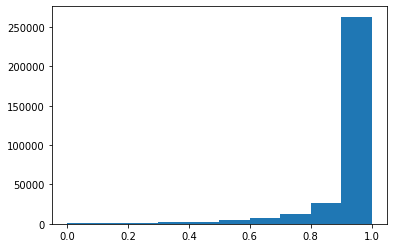

In [25]:
from matplotlib import pyplot as plt

flat = np.ndarray.flatten(res)
plt.hist(flat)
plt.show()

In [24]:
res = np.nan_to_num(res)

In [31]:
sum(res>0.5)

array([838, 848, 837, 830, 843, 840, 835, 845, 844, 832, 852, 839, 844,
       850, 841, 852, 839, 843, 843, 841, 846, 852, 830, 850, 840, 842,
       850, 851, 819, 849, 843, 825, 848, 852, 786, 838, 841, 852, 808,
       852, 841, 843, 828, 834, 845, 827, 840, 820, 742, 848, 825, 839,
       843, 783, 851, 851, 852, 847, 848, 850, 834, 841, 838, 835, 775,
       852, 843, 852, 849, 780, 717, 841, 842, 852, 814, 848, 815, 845,
       848, 852, 843,   0, 846, 842, 852, 852, 852, 852, 843, 760, 741,
       841, 810, 852, 840, 848, 819, 841, 840, 833, 853, 747, 836, 843,
       828, 843, 840, 828, 840, 846, 847, 839, 837, 852, 841, 810, 845,
       826, 848, 815, 843, 819, 815, 847, 851, 848, 838, 843, 717, 817,
       851, 843, 813, 720, 717, 844, 840, 843, 839, 839, 844, 853, 825,
       840, 825, 848, 841, 815, 819, 852, 852, 837, 835, 820, 824, 820,
       717, 848, 825, 842, 804, 844, 850, 850, 852, 839, 852, 842, 841,
       851, 841, 843, 851, 843, 843, 844, 850, 815, 843, 852, 85